In [1]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
from datetime import timedelta,date

import warnings
warnings.filterwarnings("ignore")

def GHMM_Generate(Sec):
    
    beginDate = '2006-1-1'
    endDate = '2014-12-30'
    n_state = 4

    data_raw = get_price(Sec, start_date = beginDate, end_date=endDate, frequency='daily', fields=['close','volume','money'],fq = "pre")
    
    
    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50

    Train_Data = np.column_stack([logRet_5[-data_len:], \
                              logRet_20[-data_len:], \
                              logVol_5[-data_len:], \
                              logVol_20[-data_len:], \
                              logMoney_5[-data_len:], \
                              logMoney_20[-data_len:], \
                              std[-data_len:]])
    
    
    Date = pd.to_datetime(data_raw.index[-data_len:])
    
    model = GaussianHMM(n_components= n_state, covariance_type="full", n_iter=2000).fit(Train_Data)

    hidden_states = model.predict(Train_Data)
    
    state_pd = pd.concat([pd.DataFrame(Date[-data_len:]),pd.DataFrame(list(hidden_states[-data_len:]))],axis = 1,names = ['date','state'])
    state_pd.columns = ['date','state']

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2008-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2008-10-31", "%Y-%m-%d"))]['state'].value_counts()
    state_BigLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2007-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2007-10-1", "%Y-%m-%d"))]['state'].value_counts()
    state_BigBonus = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2011-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2013-1-1", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2014-6-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2014-12-31", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorBonus = state_choose[state_choose == state_choose.max()].index[0]

    return model,state_BigLoss,state_BigBonus,state_MinorLoss,state_MinorBonus


def single_state_estimation(Sec,model_read,enddate = "2018-12-20"):
    HMM_model = model_read[0]
    state_BigLoss = model_read[1]
    state_BigBonus = model_read[2]
    state_MinorLoss = model_read[3]
    state_MinorBonus =  model_read[4]

    # 生成模型对应的参数
    data_raw = get_price(Sec, count = 100, end_date=enddate, frequency='daily', fields=['close','volume','money'],fq = "pre")

    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50


    Train_Data = np.column_stack([logRet_5[-data_len:], \
                                  logRet_20[-data_len:], \
                                  logVol_5[-data_len:], \
                                  logVol_20[-data_len:], \
                                  logMoney_5[-data_len:], \
                                  logMoney_20[-data_len:], \
                                  std[-data_len:]])
    
    

    hidden_states = HMM_model.predict(Train_Data)
    current_states = hidden_states[-1]
    
    if current_states == state_BigLoss:
        return 'bl'
    elif current_states == state_BigBonus:
        return 'bb'
    elif current_states == state_MinorLoss:
        return 'ml'
    elif current_states == state_MinorBonus:
        return 'mb'
    else:
        return 0
    


1、计算出相应的状态

时间点从'2015-1-1'至'2018-8-31'

In [2]:
model_HMM = GHMM_Generate('000300.XSHG')

state_BigLoss = model_HMM[1]
state_BigBonus = model_HMM[2]
state_MinorLoss = model_HMM[3]
state_MinorBonus = model_HMM[4]

operate_date_list = get_price('000300.XSHG', start_date = '2015-1-1', end_date= '2018-8-31', frequency='daily', \
                        fields=['close','volume','money'],fq = "pre")['close'].index

State_List = []

for date_i in list(operate_date_list):
    
    operate_date = date_i
    
    current_state = single_state_estimation('000300.XSHG',model_HMM,enddate = operate_date)
    
    State_List.append([operate_date,current_state])
    

In [3]:
# 转化为pandas数组
State_pd = pd.DataFrame(State_List)
State_pd.columns = ['date','state']
State_pd = State_pd.set_index("date")


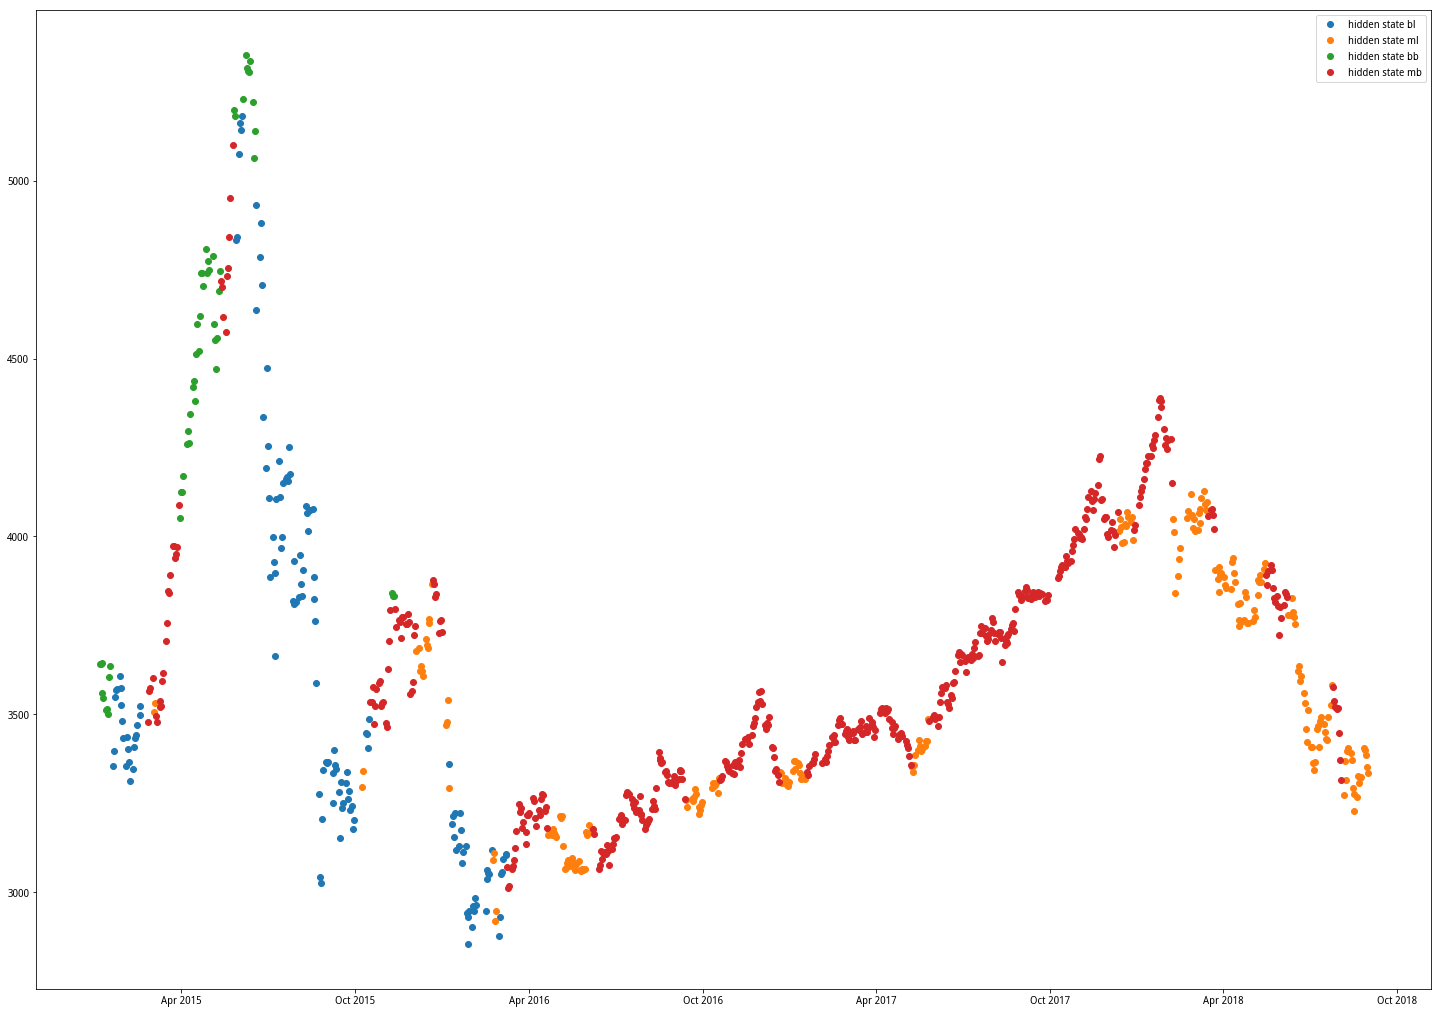

In [4]:
# 画图
Date = State_pd.index

s_date = Date[0]
e_date = Date[-1]
close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

plt.figure(figsize=(25, 18)) 

for i in ['bl','ml','bb','mb']:
    pos = list(State_pd['state']==i)
    x = State_pd[pos].index
    y = close[pos]

    plt.plot_date(x,y,'o',label='hidden state %s'%i,lw=2)
    plt.legend(loc="left")

2、计算股市收益率

按照对数收益率模拟回测

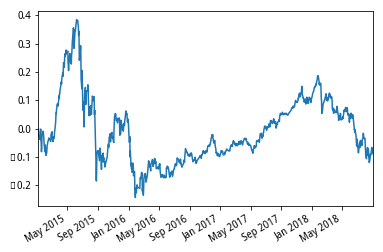

In [5]:
s_date = Date[0]
e_date = Date[-1]
market_close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

market_log_price = np.log(close).diff()

market_yield = np.cumsum(market_log_price)

# 画图
market_yield.plot()


3、计算大盘择时参数

每个状态的参数都按照一个比例进行计算，计算一段时间内（这段时间也是未来的参数）的仓位参数，通过仓位参数计算出收益率，标准有两个
1. 总的收益率越高
2. 失败概率最低

在每天的价格上增加了仓位的调整系数，这个系数是一个：持仓／总资产的数量（大于等于0）

t时刻的资产：持股资产比例 ＋ 现金资产比例

t时刻的资产：$$ 持股资产比例 * P（t+1) / P (t) + 现金资产比例 $$

引入t 时刻的持股资产比例 alpha

t 时刻的资产：$$ alpha * 1 + （1 - alpha）*1 = 1 $$
 
t + 1 时刻的资产：$$ alpha * 1 * P（t + 1) / P (t) + (1-alpha) * 1 $$

对数资产收益率：

$$ log ( alpha * 1* \frac {P（t+1)} {P (t)}  + (1-alpha)*1) 
/  1  $$

$$ log ( 1 + alpha * \frac {P(t+1) - P(t)}{P(t)} )$$

如果alpha为1，则回归到上面的公式$log(\frac {P(t+1)}{P(t)})$

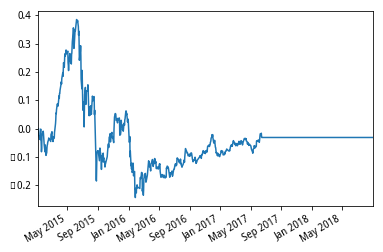

In [6]:
# 按照上面的公式的进行计算，参数假设如下：


s_date = Date[0]
e_date = Date[-1]
market_close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

market_close_pre = market_close.shift(1)
market_close_diff = market_close.diff()

# 仓位的关键参数
alpha = np.ones(len(market_close_diff))

alpha[-300:] = 0

market_log_day_yield = np.log(1 + alpha * market_close_diff/market_close_pre)


market_yield = np.cumsum(market_log_day_yield)

# 画图
market_yield.plot()



根据判断的markov状态构建alpha的序列

算法：
1. 根据过去N天的状态进行累加计算
2. 设置每个状态的权重
3. 根据状态计算出应该的持仓量alpha

In [7]:
s_date = Date[0]
e_date = Date[-1]
market_close = get_price('000300.XSHG', start_date = s_date, end_date=e_date, frequency='daily', fields=['close'],fq = "pre")['close']

market_close_pre = market_close.shift(1)
market_close_diff = market_close.diff()

data_total_pd = pd.concat([market_close,market_close_pre,market_close_diff],axis =1)

data_total_pd.columns = ['price_raw','price_pre','price_diff']
# 仓位的关键参数，初始值默认为1
alpha = np.ones(len(market_close_diff))
data_total_pd['alpha'] = alpha

# 评分，评分初始值默认为0
score = np.zeros(len(market_close_diff))
data_total_pd['score'] = score

# 相应的状态取自markov预测的状态
data_total_pd['state'] = State_pd


In [18]:
# 上限总分值：100分
total_score = 40

# 赋值相应的状态对应的分值
score_BigLoss = -4
score_BigBonus = 4
score_MinorLoss = -1
score_MinorBonus = 1

# 每个日期进行循环比对
date_operate = State_pd.index
for date_i in date_operate[:50]:

    # 状态的pandas数组
    States_pd_current = State_pd[(State_pd.index <= date_i)&(State_pd.index > (date_i - timedelta(days = 10)))]

    score_current = 0
    for index, row in States_pd_current.iterrows():
        if row['state'] == "bb":
            score_current += score_BigBonus
        elif row['state'] == "bl":
            score_current += score_BigLoss
        elif row['state'] == "mb":
            score_current += score_MinorBonus
        elif row['state'] == "ml":
            score_current += score_MinorLoss
 
    
    data_total_pd['score'][data_total_pd.index == date_i]= score_current
    

In [19]:
data_total_pd['score']

data_total_pd['alpha'] = np.where(data_total_pd['score'] > 0,data_total_pd['score']/40,0)

In [21]:
data_total_pd

,price_raw,price_pre,price_diff,alpha,score,state
2015-01-05,3641.541,NaN,NaN,0.1,4,bb
2015-01-06,3641.059,3641.541,-0.482,0.2,8,bb
2015-01-07,3643.790,3641.059,2.731,0.3,12,bb
2015-01-08,3559.259,3643.790,-84.531,0.4,16,bb
2015-01-09,3546.723,3559.259,-12.536,0.5,20,bb
2015-01-12,3513.576,3546.723,-33.147,0.6,24,bb
2015-01-13,3514.040,3513.576,0.464,0.7,28,bb
2015-01-14,3502.423,3514.040,-11.617,0.8,32,bb
2015-01-15,3604.121,3502.423,101.698,0.8,32,bb
2015-01-16,3635.146,3604.121,31.025,0.8,32,bb


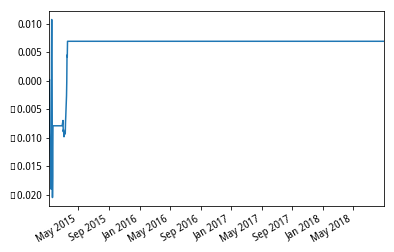

In [22]:

market_log_day_yield = np.log(1 + data_total_pd['alpha'] * data_total_pd['price_diff']/data_total_pd['price_pre'])

market_yield = np.cumsum(market_log_day_yield)

# 画图
market_yield.plot()